In [6]:
from datascience import *
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter("ignore")

## Review

In [7]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

In [9]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sum((point1-point2)**2) ** 0.5

def all_distances(training, new_row, y_name):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.drop(y_name)
    def distance_from_new(row):
        return distance(make_array(new_row), make_array(row))
    return attributes.apply(distance_from_new)


def table_with_distances(training, new_point, y_name):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point, y_name))


def nearest(training, new_point, y_name, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point, y_name)
    sorted_by_distance = with_dists.sort('Distance')
    nearest_neighbors_table = sorted_by_distance.take(np.arange(k))
    return nearest_neighbors_table


## New material

In [10]:
all_sales = Table.read_table('house.csv')

In [11]:
sales = all_sales.where('Bldg Type', '1Fam').where('Sale Condition', 'Normal').select(
    'SalePrice', '1st Flr SF', '2nd Flr SF', 
    'Total Bsmt SF', 'Garage Area', 
    'Wood Deck SF', 'Open Porch SF', 'Lot Area', 
    'Year Built', 'Yr Sold')

Exploration!

In [12]:
sales.num_rows

2002

In [13]:
sales.sample(6).show(6)

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
152000,1141,0,1141,484,182,0,7500,2006,2009
137000,1024,704,704,234,245,60,9462,1949,2006
113000,798,689,735,220,0,140,8741,1945,2010
266500,1188,1152,1152,252,0,60,9042,1941,2010
189900,928,701,928,482,212,34,13830,1997,2010
123000,1040,0,1040,264,0,90,11677,1966,2007


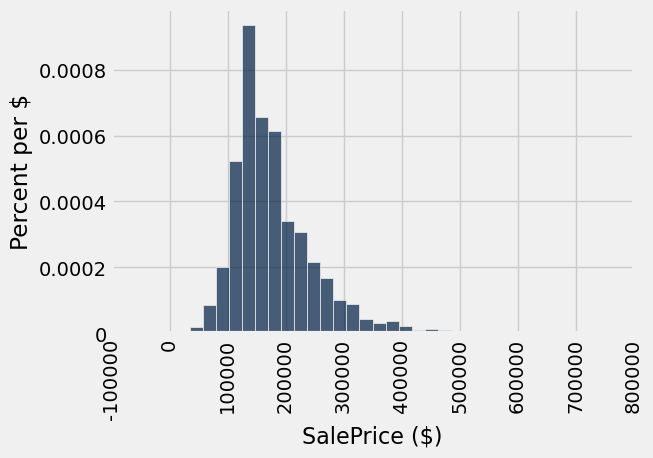

In [14]:
sales.hist('SalePrice', bins=32, unit='$')

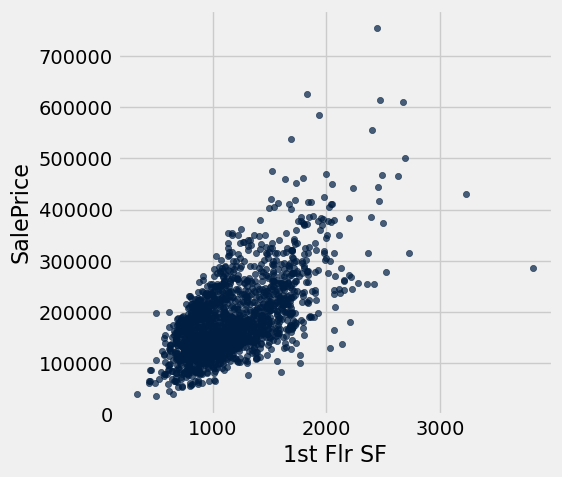

In [15]:
sales.scatter('1st Flr SF', 'SalePrice')

In [16]:
correlation(sales, 'SalePrice', '1st Flr SF')

0.64246625410302249

- It's always a good idea to take a look at each of the variables in some capacity.
    -  To make the demo shorter we will just look at the $r$ for each variable, but you should look at the plots as well.

In [17]:
for label in sales.labels:
    print('Correlation of', label, 'and SalePrice:\t', correlation(sales, label, 'SalePrice'))

Correlation of SalePrice and SalePrice:	 1.0
Correlation of 1st Flr SF and SalePrice:	 0.642466254103
Correlation of 2nd Flr SF and SalePrice:	 0.35752189428
Correlation of Total Bsmt SF and SalePrice:	 0.652978626757
Correlation of Garage Area and SalePrice:	 0.638594485252
Correlation of Wood Deck SF and SalePrice:	 0.352698666195
Correlation of Open Porch SF and SalePrice:	 0.336909417026
Correlation of Lot Area and SalePrice:	 0.290823455116
Correlation of Year Built and SalePrice:	 0.565164753714
Correlation of Yr Sold and SalePrice:	 0.0259485790807


______

For ease of computational efficiency, we will use the five variables having the highest correlation coefficients with `SalePrice`.

In [18]:
sales = sales.select(0, 1, 2, 3, 4, 8)
sales.show(3)

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built
215000,1656,0,1080,528,1960
105000,896,0,882,730,1961
172000,1329,0,1329,312,1958


### How is an MLR estimate calculated?

This is a 50/50 train-test split.

In [30]:
halfway_split_point = round(sales.num_rows/2)
sales_shuffled = sales.sample(with_replacement = False)

In [31]:
train = sales_shuffled.take(np.arange(halfway_split_point))
test = sales_shuffled.take(np.arange(halfway_split_point, sales.num_rows))

**Task**: Find the best slopes for the linear regression model:

$$\text{estimate of sale price} = a*\text{1st floor SF} + b*\text{2nd floor SF} + c*\text{Bsmt SF} + d*\text{Garage Area} + e*\text{Year Built} + f$$

We are going to find the best slopes in the model by minimization. Let's set up our equation to do this in a function!

In [32]:
def sales_train_rmse(a,b,c,d,e,f):

    y = train.column('SalePrice')
    
    first_floor = train.column('1st Flr SF')
    second_floor = train.column('2nd Flr SF')
    basement = train.column('Total Bsmt SF')
    garage = train.column('Garage Area')
    year = train.column('Year Built')
    
    estimate = a*first_floor + b*second_floor + c*basement + d*garage + e*year + f
    
    return (np.mean((y - estimate) ** 2)) ** 0.5

You do not need to be concerned with how to supply the `start` argument in `minimize()`. We will do this for you. In this case, we generated the starting slopes at random from a normal distribution with mean 10 and standard deviation of 1.

In [33]:
example_slopes = np.random.normal(10, 1, len(train.row(0)))

The `smooth` argument will always read `True` for our purposes!

In [34]:
minimize(sales_train_rmse, start=example_slopes, smooth=True)

array([  8.92324907e+01,   8.18360974e+01,   4.12152702e+01,
         5.66636127e+01,   5.43575219e+02,  -1.08854332e+06])

**STOP**

**Task**: Find the fitted values (sale price predictions on the *training* set) for our model.

In [36]:
def sales_estimate(data, a,b,c,d,e,f):

    first_floor = data.column('1st Flr SF')
    second_floor = data.column('2nd Flr SF')
    basement = data.column('Total Bsmt SF')
    garage = data.column('Garage Area')
    year = data.column('Year Built')
    
    return a*first_floor + b*second_floor + c*basement + d*garage + e*year + f

In [37]:
fitted_values = sales_estimate(train, 7.98166017e+01,   7.49587080e+01,   4.92413986e+01,
         6.23035142e+01,   4.77631901e+02,  -9.56943066e+05)

### How can we evaluate our model fit?

In [38]:
fit_table = Table().with_columns('Actual', train.column('SalePrice'),
                                'Fitted',  fitted_values,
                                'Residuals', (train.column('SalePrice') - fitted_values))

In [40]:
fit_table.sample(3)

Actual,Fitted,Residuals
141000,145846,-4845.58
143000,188846,-45846
261500,242479,19020.8


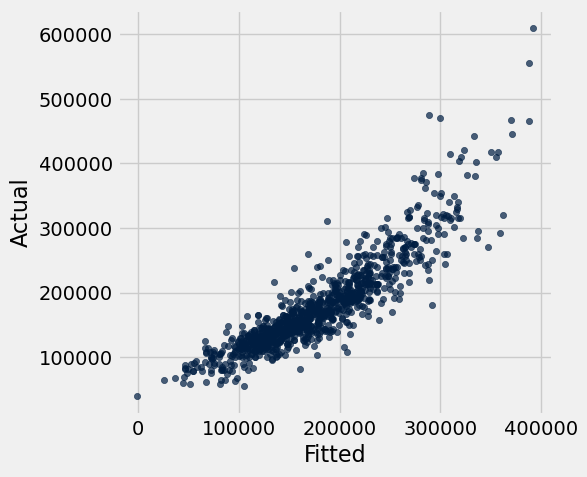

In [25]:
fit_table.scatter('Fitted','Actual')

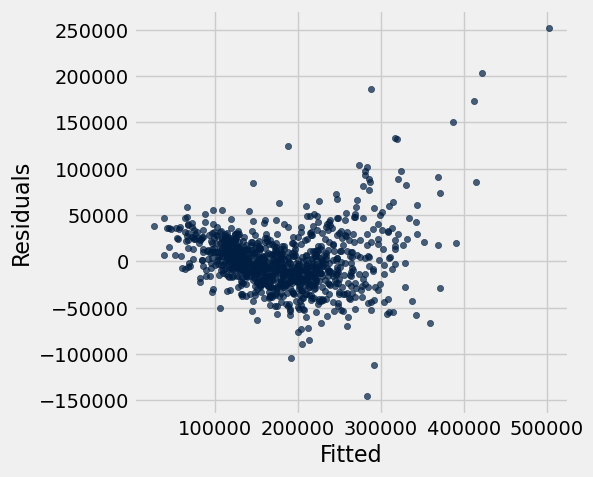

In [42]:
fit_table.scatter('Fitted', 'Residuals')

In [ ]:
fit_table.scatter('First Sq Sf')

### How we evaluate the accuracy of an MLR model?

**Task** calculate the RMSE between:

- the predicted house prices of the testing data
- the actual house prices of the testing data

- Since we are now working from a predictive standpoint, I'm going to *standardize* the train and test set first. 
- Then we'll refit the model with the standardized training data and make predictions on the standardized test set.

In [45]:
std_train = train.select('SalePrice').with_columns(
    '1st Flr SF', standard_units(train.column('1st Flr SF')),
    '2nd Flr SF', standard_units(train.column('2nd Flr SF')),
    'Total Bsmt SF', standard_units(train.column('Total Bsmt SF')),
    'Garage Area', standard_units(train.column('Garage Area')),
    'Year Built', standard_units(train.column('Year Built')),
)

In [53]:
std_test = test.select('SalePrice').with_columns(
    '1st Flr SF', standard_units(test.column('1st Flr SF')),
    '2nd Flr SF', standard_units(test.column('2nd Flr SF')),
    'Total Bsmt SF', standard_units(test.column('Total Bsmt SF')),
    'Garage Area', standard_units(test.column('Garage Area')),
    'Year Built', standard_units(test.column('Year Built')),
)

In [54]:
def sales_train_rmse(a,b,c,d,e,f):

    y = train.column('SalePrice')
    
    first_floor = std_train.column('1st Flr SF')
    second_floor = std_train.column('2nd Flr SF')
    basement = std_train.column('Total Bsmt SF')
    garage = std_train.column('Garage Area')
    year = std_train.column('Year Built')
    
    estimate = a*first_floor + b*second_floor + c*basement + d*garage + e*year + f
    
    return (np.mean((y - estimate) ** 2)) ** 0.5

In [56]:
minimize(sales_train_rmse, start=example_slopes, smooth=True)

array([  30840.02298847,   36131.05551036,   16345.59351761,
         11692.22809447,   16410.32990701,  180664.19647388])

In [57]:
def sales_test_rmse(a,b,c,d,e,f):

    y = std_test.column('SalePrice')
    
    first_floor = std_test.column('1st Flr SF')
    second_floor = std_test.column('2nd Flr SF')
    basement = std_test.column('Total Bsmt SF')
    garage = std_test.column('Garage Area')
    year = std_test.column('Year Built')
    
    estimate = a*first_floor + b*second_floor + c*basement + d*garage + e*year + f
    
    return (np.mean((y - estimate) ** 2)) ** 0.5

In [58]:
sales_test_rmse(30840.02298847,   36131.05551036,   16345.59351761,
         11692.22809447,  16410.32990701,  180664.19647388)

32498.865519132705

**STOP**

### We can bring nearest neighbors to linear regression, too!

In [68]:
example_row = std_test.drop(0).row(0)
example_row

Row(1st Flr SF=1.8154300083633805, 2nd Flr SF=-0.78192723794423769, Total Bsmt SF=1.9769654653608091, Garage Area=0.2781833449112765, Year Built=1.3235552954711589)

In [69]:
nearest(std_train, example_row, 'SalePrice', 5)

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built,Distance
236500,1.88553,-0.826601,1.83007,0.266065,1.13033,0.256847
216837,2.02441,-0.826601,2.1,0.0817529,1.2296,0.328966
200000,1.63093,-0.826601,1.65096,0.372772,1.19651,0.409149
232000,1.53835,-0.826601,1.58789,0.169059,1.19651,0.508131
247900,1.57885,-0.826601,1.60555,0.295167,0.99797,0.549735


In [70]:
def nn_5_regression_estimate(new_point):
    return np.average(nearest(std_train, new_point, 'SalePrice', 5).column('SalePrice'))

In [71]:
nn_5_regression_estimate(example_row)

226647.39999999999

Perform a 5-nearest neighbors regression on all testing points.

In [72]:
predictions = std_test.drop('SalePrice').apply(nn_5_regression_estimate)

Calculate the $\text{RMSE}$ for our model!

In [73]:
(np.mean((std_test.column('SalePrice') - predictions) ** 2)) ** 0.5

30563.456384303208